In [78]:
# Use np.nan for NaN values, do not import NaN directly from numpy

from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date, auto_adjust=False).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed

4 Failed downloads:
['GEV', 'SW', 'SOLV', 'VLTO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.251017   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.536377   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.061218   52.790001   54.189999   51.880001   53.099998   
           ABT      32.820744   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      87.701065   89.519997   90.849998   89.500000   90.379997   
           YUM     119.860710  124.010002  124.739998  123.449997  124.239998   
           ZBH     110.513573  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     173.604691  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
           ACGL      1888800.0  
...                        ...  
2023-09-26 XYL       1322400.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[980418 rows x 6 columns]

In [90]:

# Compute RSI manually
def compute_rsi(series, length=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.rolling(window=length, min_periods=length).mean()
    avg_loss = loss.rolling(window=length, min_periods=length).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Compute Bollinger Bands manually
def compute_bbands(series, length=20, num_std=2):
    sma = series.rolling(window=length, min_periods=length).mean()
    std = series.rolling(window=length, min_periods=length).std()
    upper_band = sma + num_std * std
    lower_band = sma - num_std * std
    return lower_band, sma, upper_band

# Compute Bollinger Bands (on log1p of adj close)
def bbands_transform(x):
    log_prices = np.log1p(x)
    low, mid, high = compute_bbands(log_prices, length=20)
    return pd.DataFrame({
        'bb_low': low,
        'bb_mid': mid,
        'bb_high': high
    }, index=x.index)

# Compute ATR manually and standardize it
def compute_atr(stock_data, length=14):
    high = stock_data['high']
    low = stock_data['low']
    close = stock_data['adj close']

    prev_close = close.shift(1)
    tr = pd.concat([
        high - low,
        (high - prev_close).abs(),
        (low - prev_close).abs()
    ], axis=1).max(axis=1)

    atr = tr.rolling(window=length, min_periods=length).mean()
    atr_zscore = (atr - atr.mean()) / atr.std()
    return atr_zscore

# Compute MACD manually and standardize it
def compute_macd(series, fast=12, slow=26):
    ema_fast = series.ewm(span=fast, min_periods=fast).mean()
    ema_slow = series.ewm(span=slow, min_periods=slow).mean()
    macd_line = ema_fast - ema_slow
    macd_zscore = (macd_line - macd_line.mean()) / macd_line.std()
    return macd_zscore

# Garman-Klass volatility estimator
df['garman_klass_vol'] = (
    ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2
    - (2 * np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open'])) ** 2)
)

# Compute RSI grouped by level 1
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: compute_rsi(x, length=20))

# Compute Bollinger Bands grouped by level 1
bb_df = df.groupby(level=1)['adj close'].apply(bbands_transform)
df[['bb_low', 'bb_mid', 'bb_high']] = bb_df.reset_index(level=0, drop=True)

# Compute ATR grouped by level 1
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# Compute MACD grouped by level 1
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].transform(lambda x: compute_macd(x))

df['dollar_volume'] = (df['adj close']* df['volume'])/1e6

df


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.251017   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.536377   27.264999   28.377501   26.965000   28.207500   
           ABBV     35.061218   52.790001   54.189999   51.880001   53.099998   
           ABT      32.820744   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      87.701065   89.519997   90.849998   89.500000   90.379997   
           YUM     119.860710  124.010002  124.739998  123.449997  124.239998   
           ZBH     110.513573  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     173.604691  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001351        NaN       NaN   
           AAPL    293461600.0         -0.006207        NaN       NaN   
           ABBV     12842800.0         -0.065607        NaN       NaN   
           ABT      12287500.0         -0.011997        NaN       NaN   
           ACGL      1888800.0         -0.000516        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000238  22.653431  4.472030   
           YUM       1500600.0         -0.000443  36.971531  4.791669   
           ZBH       3610500.0         -0.000336  41.303588  4.735736   
           ZBRA       355400.0          0.000133  21.657597  5.397402   
           ZTS       1463200.0         -0.000036  37.270254  5.143515   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.389790  
           AAPL         NaN       NaN       NaN       NaN    7200.484439  
           ABBV         NaN       NaN       NaN       NaN     450.284214  
           ABT          NaN       NaN       NaN       NaN     403.284887  
           ACGL         NaN       NaN       NaN       NaN      43.853730  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.556072  4.640113 -3.011216 -2.157409     115.975888  
           YUM     4.822408  4.853147 -2.828857 -1.367167     179.862982  
           ZBH     4.776429  4.817123 -2.226915 -0.878965     399.009254  
           ZBRA    5.539167  5.680932 -0.078248 -1.600810      79.595386  
           ZTS     5.203852  5.264190 -0.506077 -1.186640     254.018383  

[980418 rows x 14 columns]

In [91]:


last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data



dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          134.988337   38.734951         -0.002430  70.422634   
           AAPL      4005.252731   26.729134         -0.003654  48.630963   
           ABBV       325.730942   38.977570         -0.070930  46.106782   
           ABT        207.499331   37.540985         -0.013992  50.738928   
           ACGL        28.174423   22.970539         -0.001121  30.793654   
...                          ...         ...               ...        ...   
2023-09-30 EXE        116.689769   79.277855         -0.000348  43.297811   
           COIN       506.793576   70.519997          0.001007  46.416531   
           CEG        195.364205  107.145668         -0.000064  56.041815   
           GEHC       211.929505   66.022308          0.000183  41.379297   
           KVUE       646.494245   19.281164         -0.001506  32.942856   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.536910  3.611226  3.685542 -0.915928  0.440817  
           AAPL    3.276064  3.320493  3.364922 -0.494416 -0.209164  
           ABBV    3.690632  3.740093  3.789553  0.344525  0.018850  
           ABT     3.636157  3.658567  3.680977  0.049595  0.121017  
           ACGL    3.177527  3.195190  3.212853 -1.119424 -0.551905  
...                     ...       ...       ...       ...       ...  
2023-09-30 EXE     4.368069  4.422967  4.477865 -1.840200 -0.828974  
           COIN    4.270839  4.378785  4.486731 -1.113593  0.008323  
           CEG     4.644504  4.685718  4.726932 -0.095325  0.371209  
           GEHC    4.152334  4.211363  4.270392 -0.700163 -1.176710  
           KVUE    2.977257  3.054020  3.130783 -2.231697 -1.514010  

[46290 rows x 9 columns]

In [92]:


data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data



adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAPL     26.090458         -0.002767  53.857798  3.288995   
           ABBV     38.834366         -0.056807  25.623824  3.717208   
           ABT      33.619488         -0.009785  33.584981  3.534045   
           ACN     101.760155         -0.006263  38.045337  4.619587   
           ADBE    107.510002          0.000059  46.160151  4.679120   
...                       ...               ...        ...       ...   
2023-09-30 CRWD    160.479996          0.000144  65.687578  5.024174   
           PLTR     13.960000          0.000214  45.277776  2.699917   
           DASH     74.580002          0.000326  40.373286  4.327250   
           ABNB    132.279999          0.000213  56.841285  4.854868   
           COIN     70.519997          0.001007  46.416531  4.270839   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAPL    3.318620  3.348245 -1.004340 -0.194257  
           ABBV    3.772733  3.828259 -0.101567 -0.758456  
           ABT     3.585802  3.637559 -1.060312 -0.646879  
           ACN     4.631525  4.643462 -0.491809 -0.132575  
           ADBE    4.694639  4.710159 -1.180271 -0.107781  
...                     ...       ...       ...       ...  
2023-09-30 CRWD    5.103696  5.183218 -0.894312  0.250658  
           PLTR    2.779743  2.859570 -0.490510 -0.433592  
           DASH    4.403906  4.480561 -1.083109 -0.102635  
           ABNB    4.940924  5.026980 -0.961350 -0.010573  
           COIN    4.378785  4.486731 -1.113593  0.008323  

[12516 rows x 8 columns]

In [93]:


def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data



adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAPL     39.529034         -0.001263  75.670095  3.588975   
           ABBV     65.125298         -0.042703  52.833425  4.160361   
           ABT      47.540348         -0.007128  54.700517  3.872516   
           ACN     127.138969         -0.005423  81.931034  4.784164   
           ADBE    175.160004          0.000067  77.957910  4.948186   
...                       ...               ...        ...       ...   
2023-09-30 CRWD    160.479996          0.000144  65.687578  5.024174   
           PLTR     13.960000          0.000214  45.277776  2.699917   
           DASH     74.580002          0.000326  40.373286  4.327250   
           ABNB    132.279999          0.000213  56.841285  4.854868   
           COIN     70.519997          0.001007  46.416531  4.270839   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAPL    3.637059  3.685144 -0.543959 -0.037582   0.096808   
           ABBV    4.207901  4.255442  1.795616  0.477133   0.022728   
           ABT     3.896688  3.920860 -0.349538  0.282161   0.021276   
           ACN     4.824869  4.865574 -0.206885  0.355248   0.064180   
           ADBE    5.089292  5.230398 -0.710748  0.613325   0.174152   
...                     ...       ...       ...       ...        ...   
2023-09-30 CRWD    5.103696  5.183218 -0.894312  0.250658  -0.015641   
           PLTR    2.779743  2.859570 -0.490510 -0.433592  -0.068091   
           DASH    4.403906  4.480561 -1.083109 -0.102635  -0.113515   
           ABNB    4.940924  5.026980 -0.961350 -0.010573   0.005549   
           COIN    4.378785  4.486731 -1.113593  0.008323  -0.114070   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAPL     0.015249   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728  
           ADBE     0.062497   0.061392   0.045993   0.049515    0.041515  
...                      ...        ...        ...        ...         ...  
2023-09-30 CRWD    -0.003656   0.029981   0.026391   0.047942   -0.002216  
           PLTR    -0.161174  -0.030723   0.087272   0.090143    0.046083  
           DASH    -0.093658  -0.008091   0.027006   0.048207    0.034568  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  
           COIN    -0.154340  -0.004822   0.007147   0.079010    0.007477  

[10339 rows x 14 columns]

In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.names = ['date']

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

KeyError: "['RF'] not found in axis"

In [84]:


observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAPL    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.096808
           ABBV    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.022728
           ABT     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.021276
           ACN     0.0225 -0.0191  0.0013  0.0092 -0.0314   0.064180
           ADBE    0.0225 -0.0191  0.0013  0.0092 -0.0314   0.174152
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VZ     -0.0523 -0.0176  0.0148  0.0193 -0.0077  -0.056890
           WDAY   -0.0523 -0.0176  0.0148  0.0193 -0.0077  -0.062413
           WFC    -0.0523 -0.0176  0.0148  0.0193 -0.0077  -0.015500
           WMT    -0.0523 -0.0176  0.0148  0.0193 -0.0077  -0.000677
           XOM    -0.0523 -0.0176  0.0148  0.0193 -0.0077   0.046947

[10308 rows x 6 columns]

In [88]:


betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 



Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VZ      0.332871 -0.161914  0.271797  0.322041  0.101615
           WDAY    1.079640 -0.947248 -0.557469 -0.906769 -0.250535
           WFC     1.112740  0.257064  2.040612 -0.472583 -1.546788
           WMT     0.704616 -0.316997 -0.400225 -0.143194  0.497980
           XOM     0.974994 -1.118670  1.720717 -0.655852 -0.362732

[10308 rows x 5 columns]

In [89]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = data.join(betas.groupby('ticker').shift(), rsuffix='_shifted')


data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))


data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

KeyError: "['adj close'] not found in axis"

In [77]:


from sklearn.cluster import KMeans


def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data



ValueError: The shape of the initial centers (4, 18) does not match the number of features of the data 28.

In [33]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return



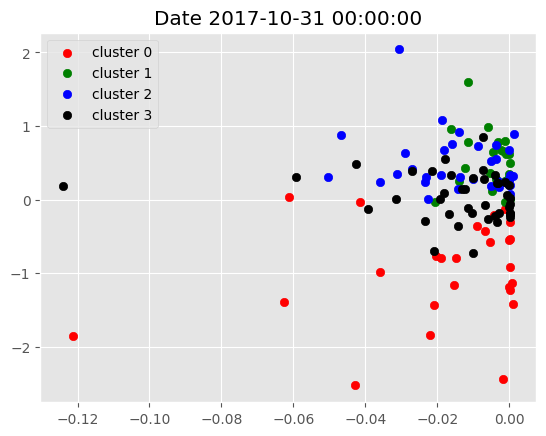

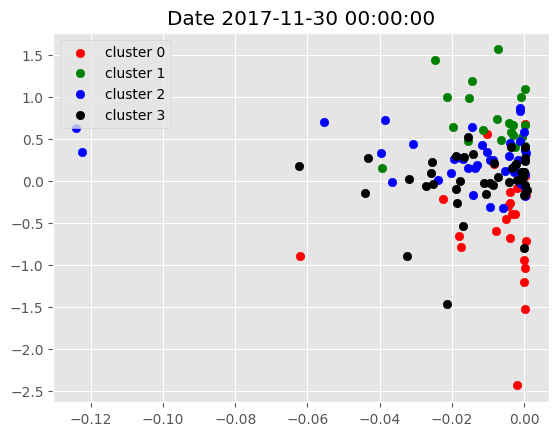

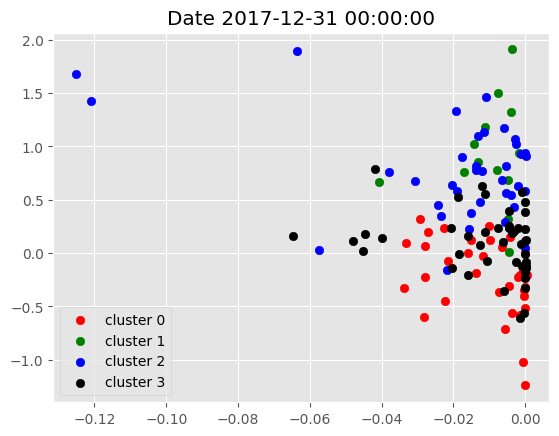

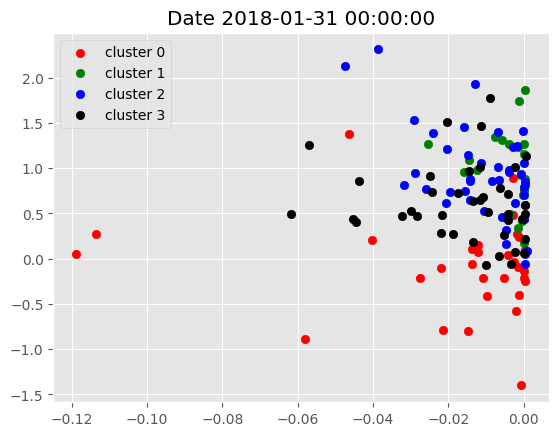

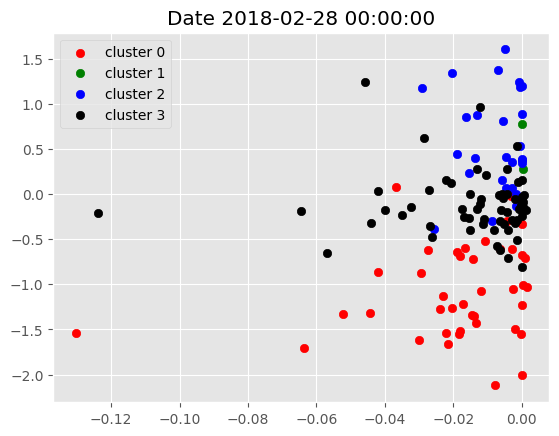

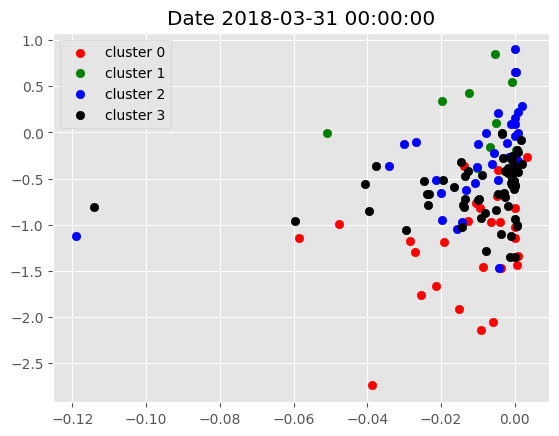

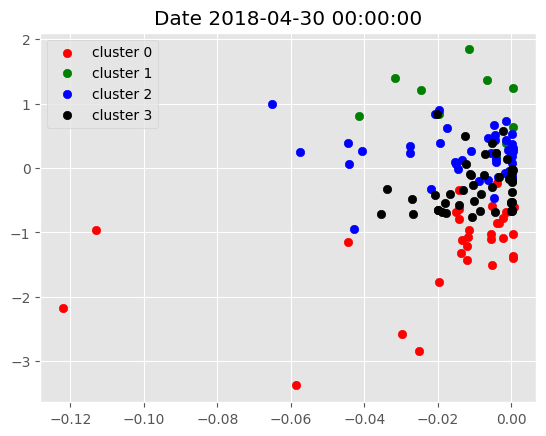

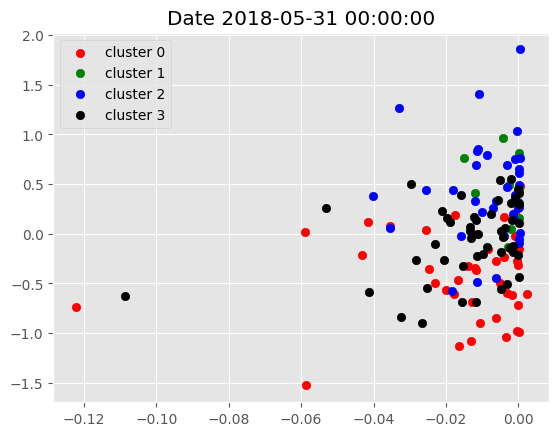

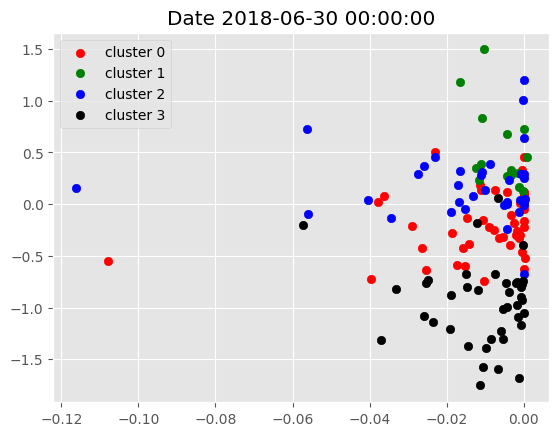

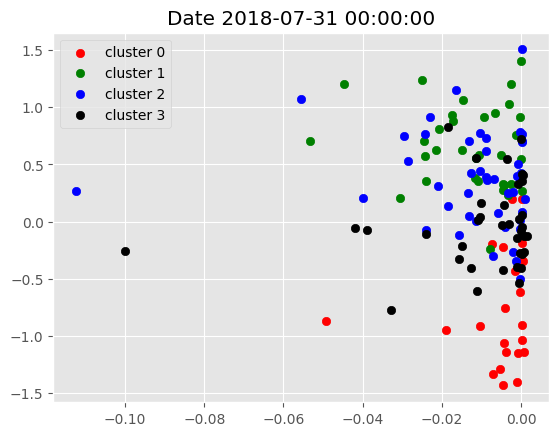

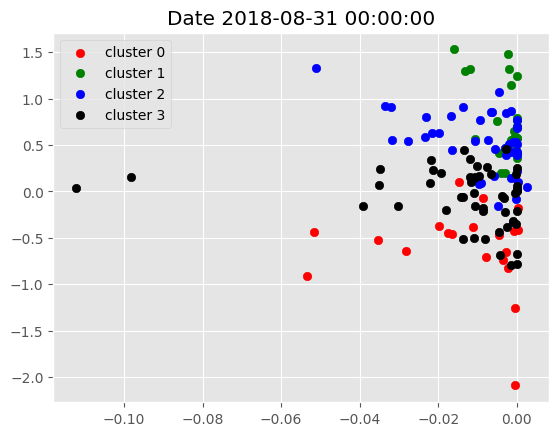

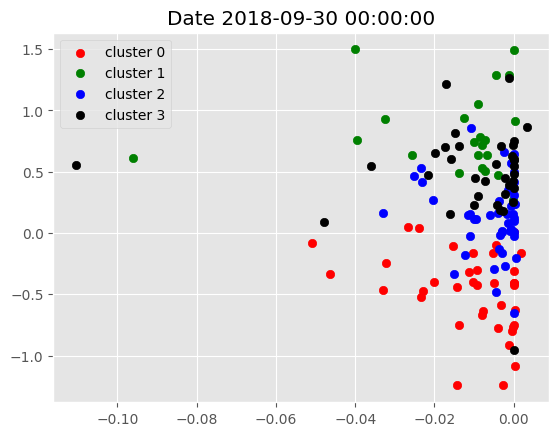

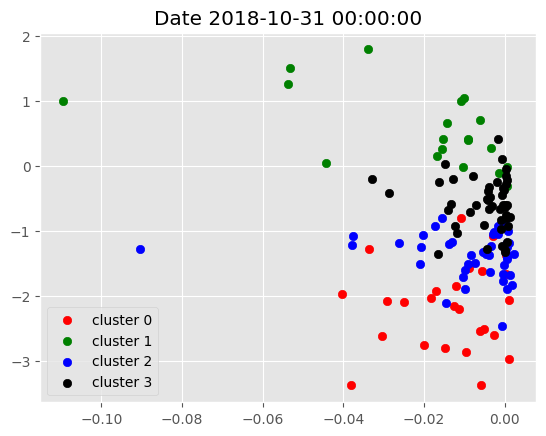

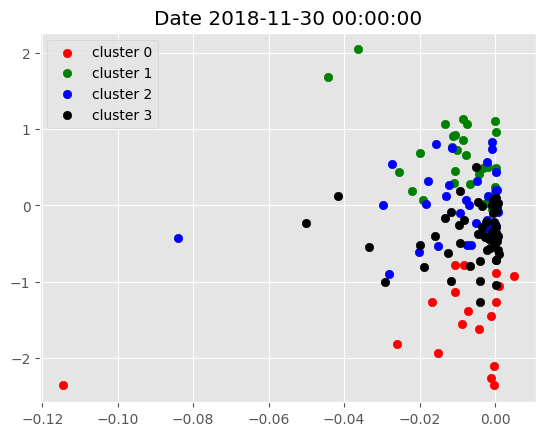

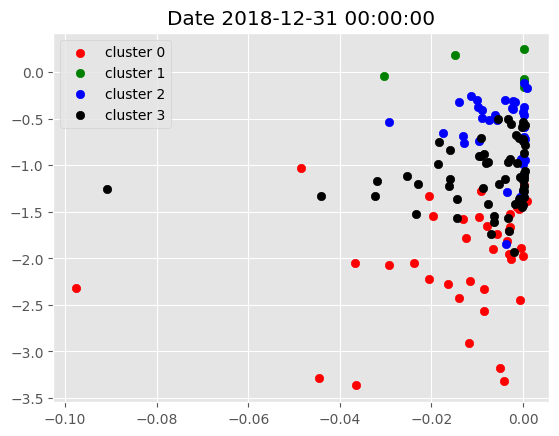

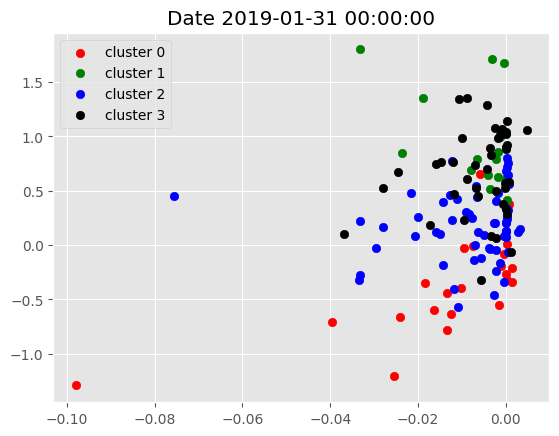

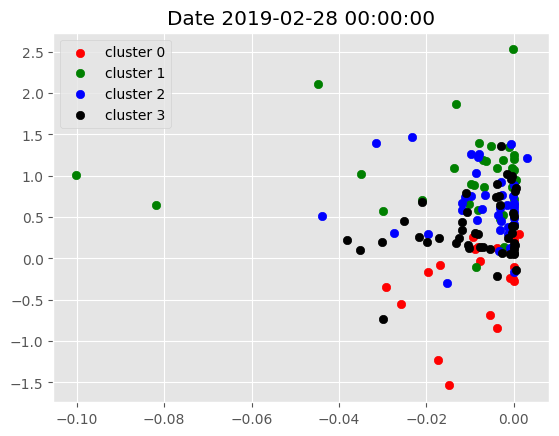

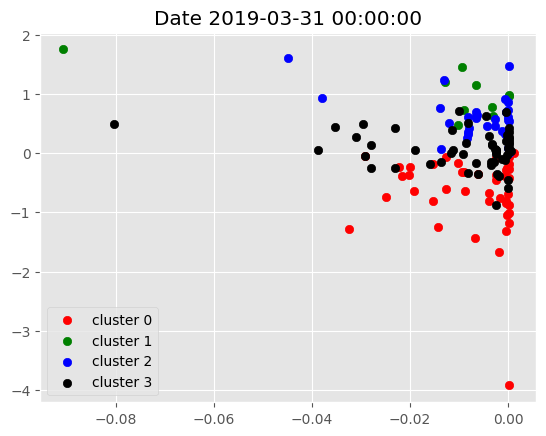

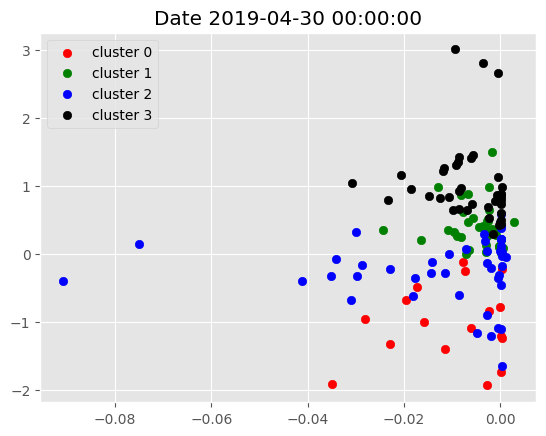

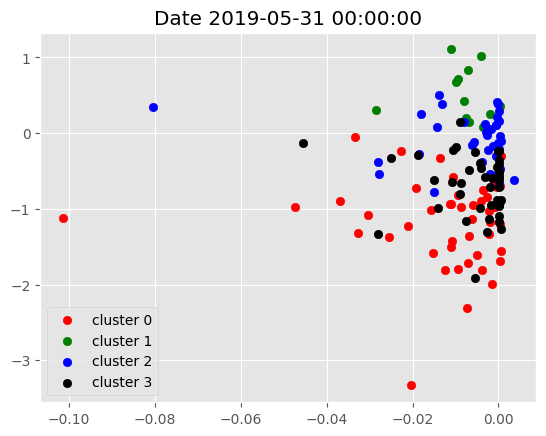

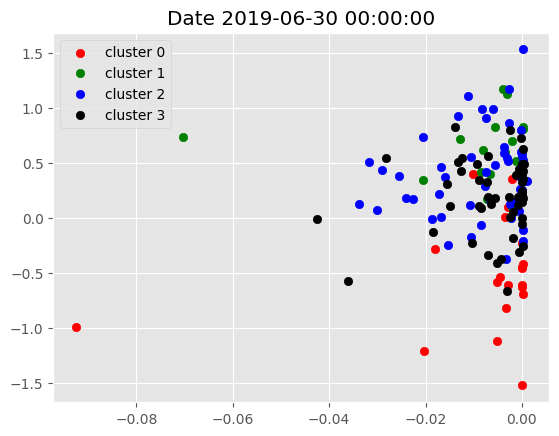

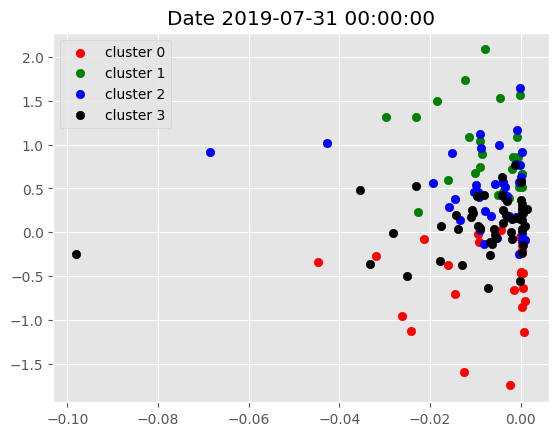

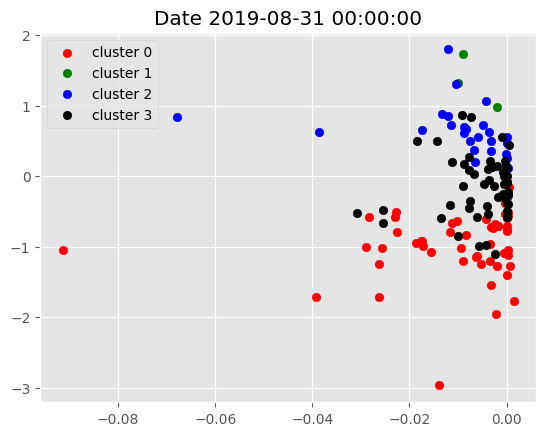

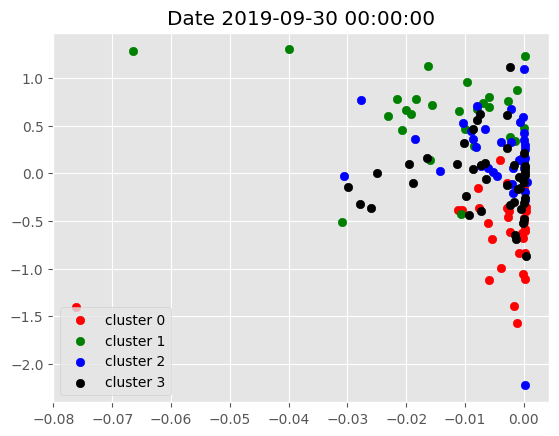

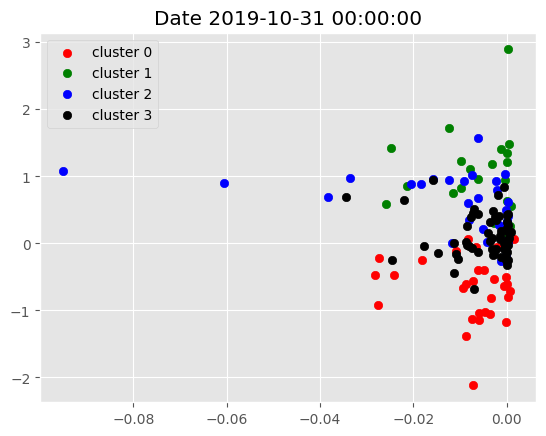

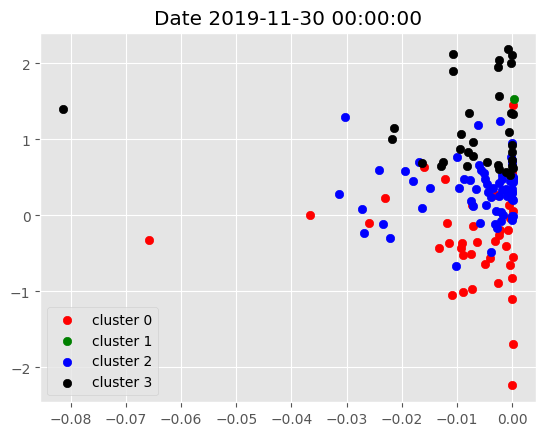

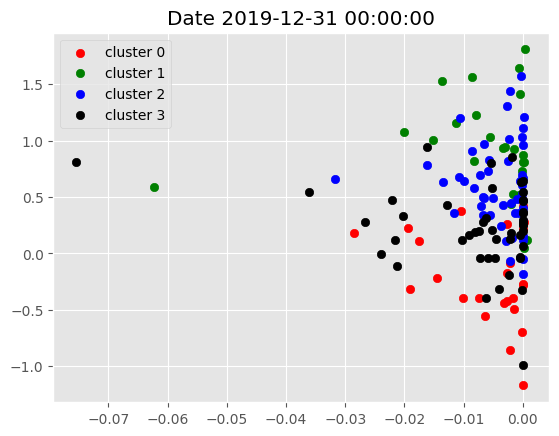

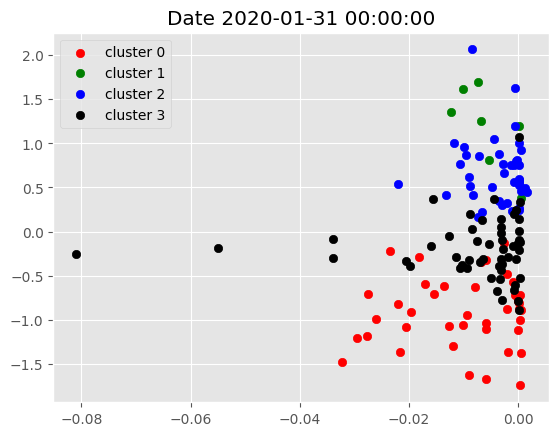

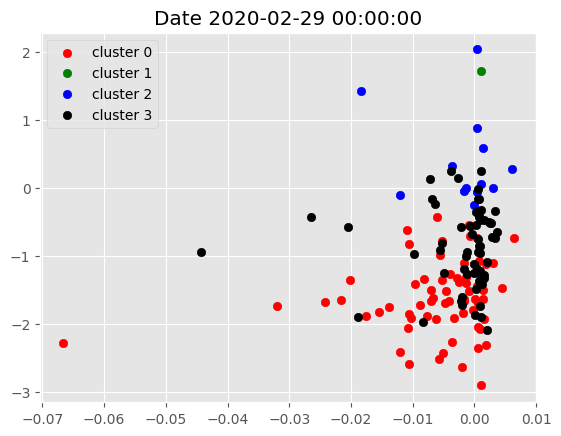

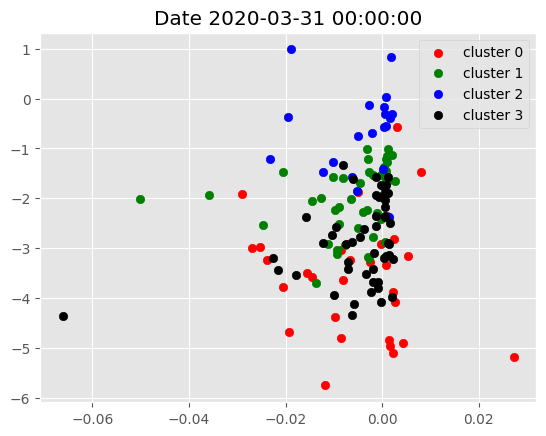

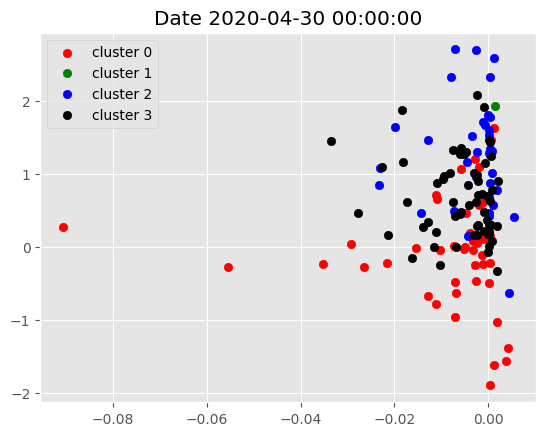

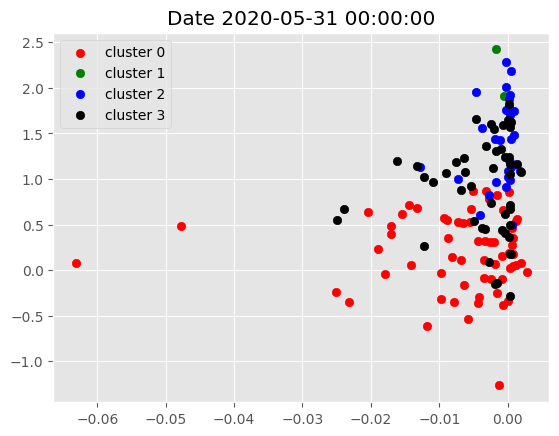

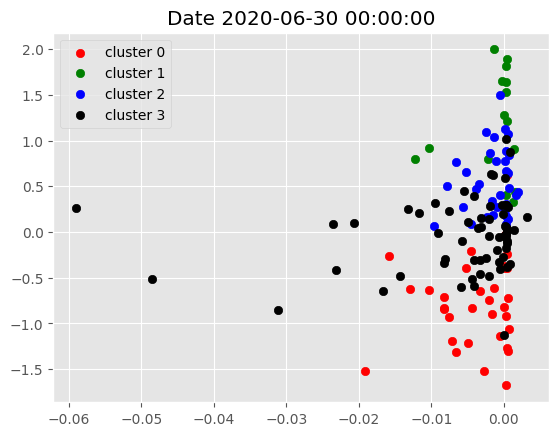

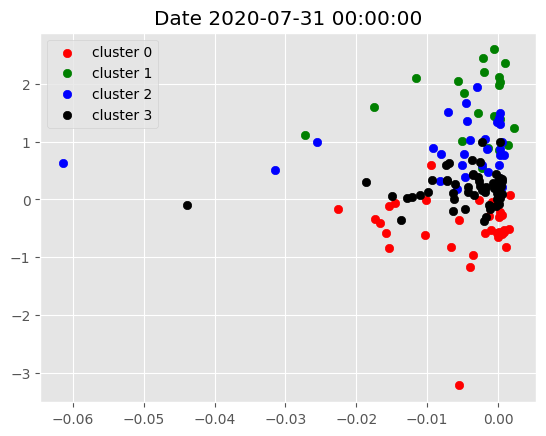

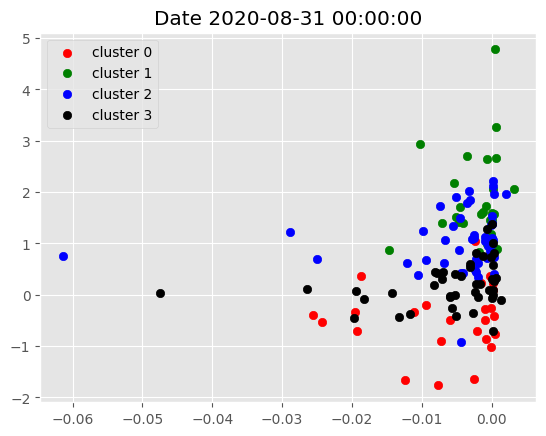

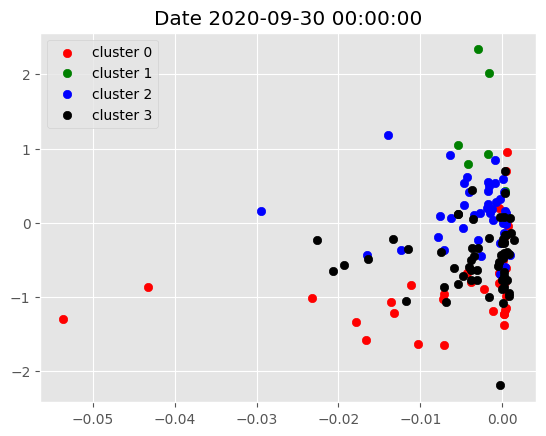

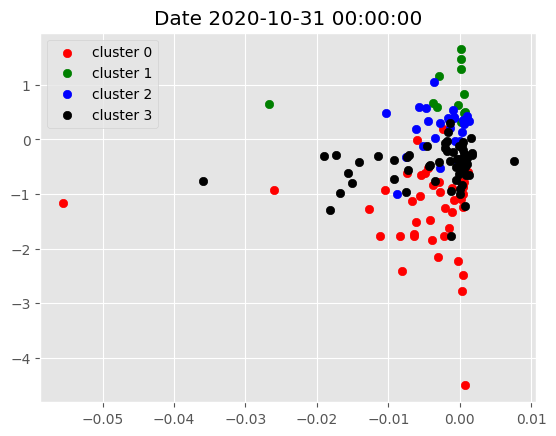

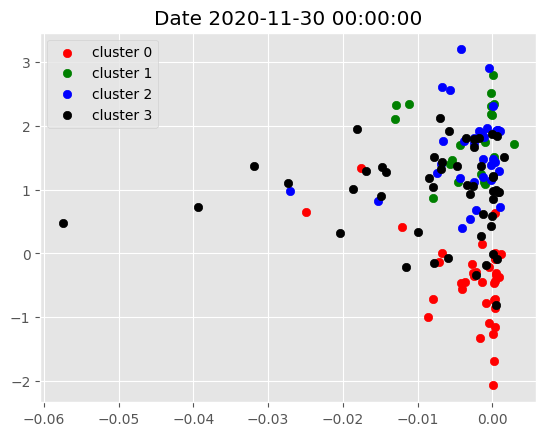

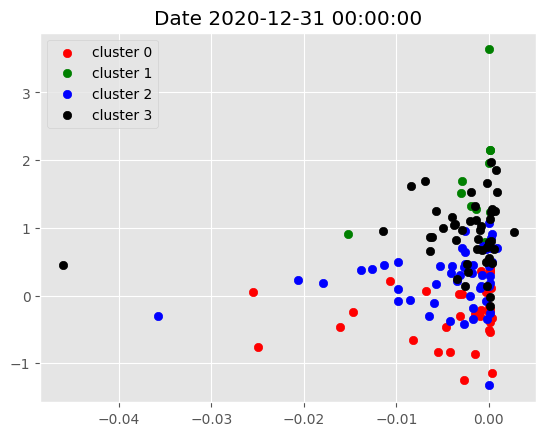

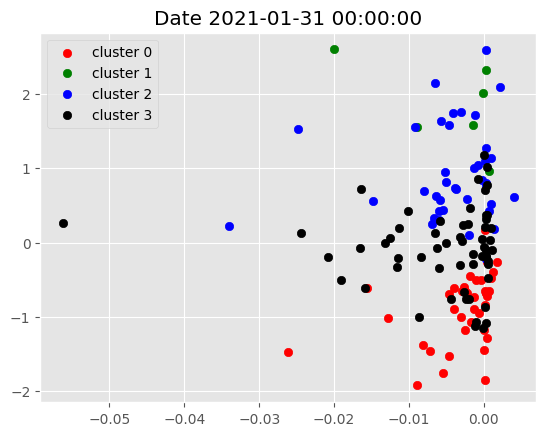

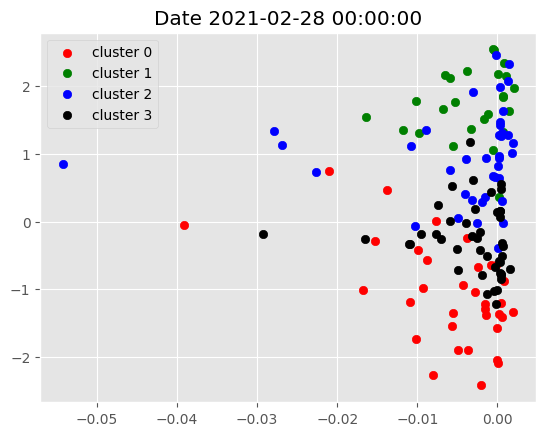

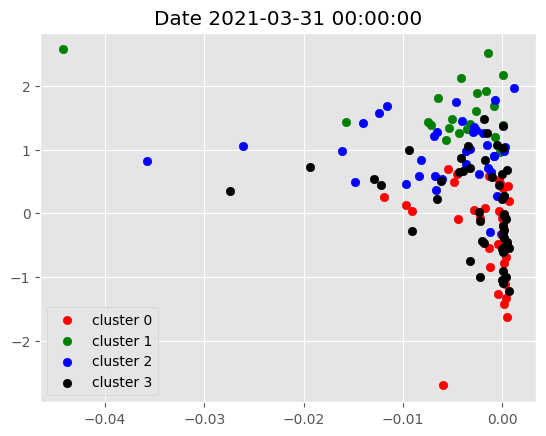

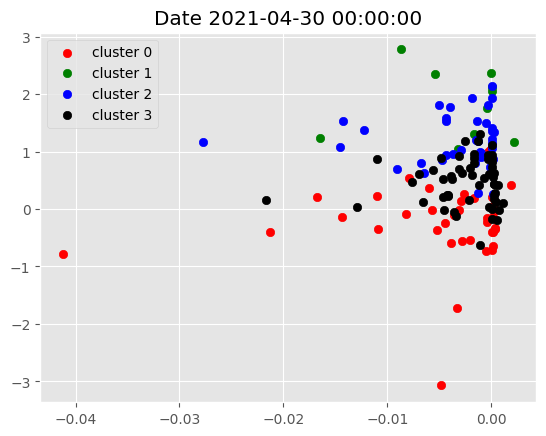

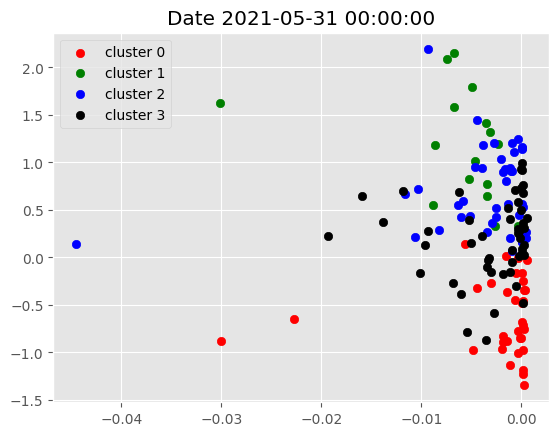

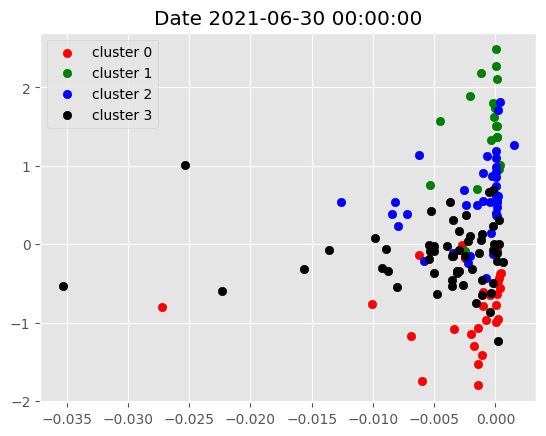

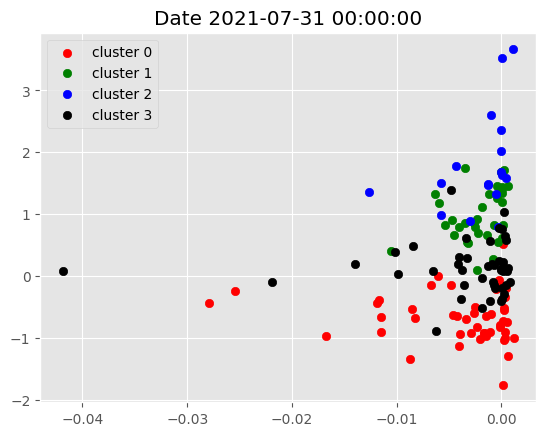

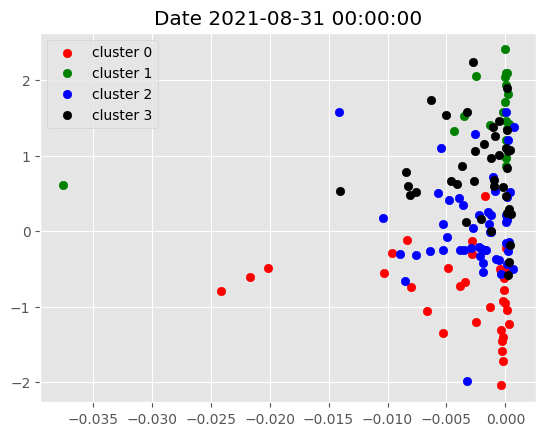

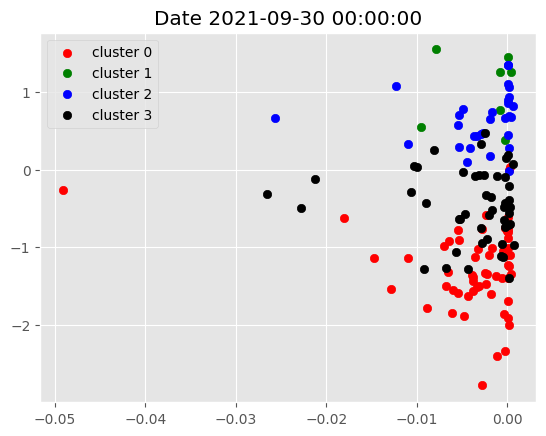

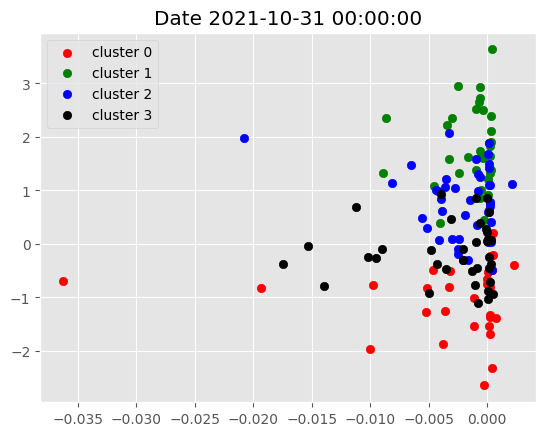

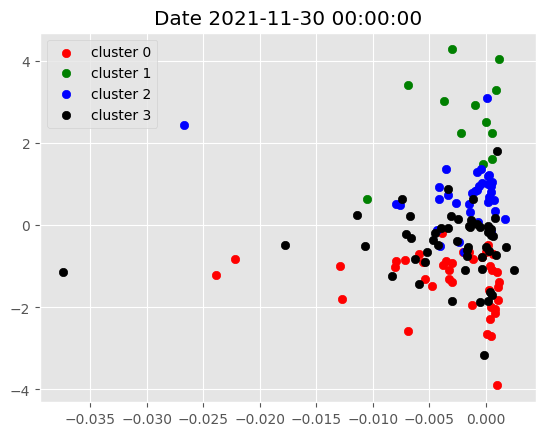

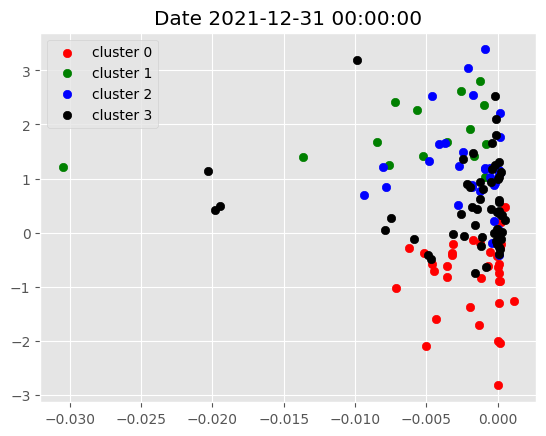

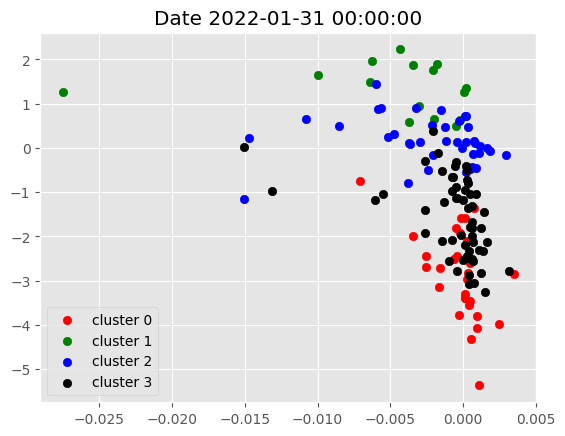

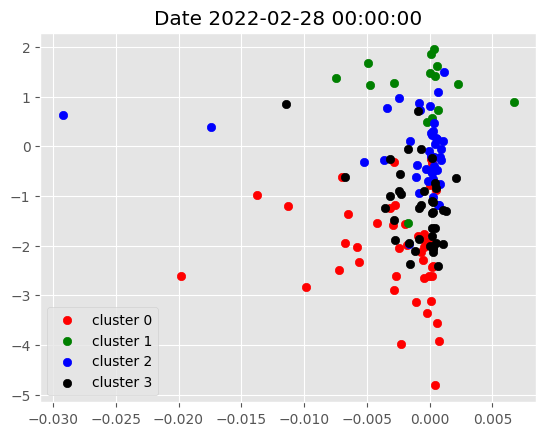

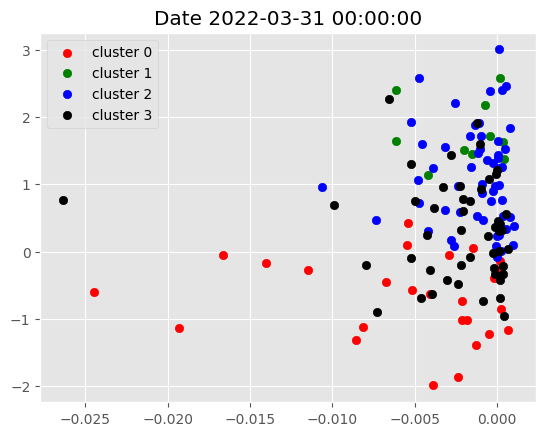

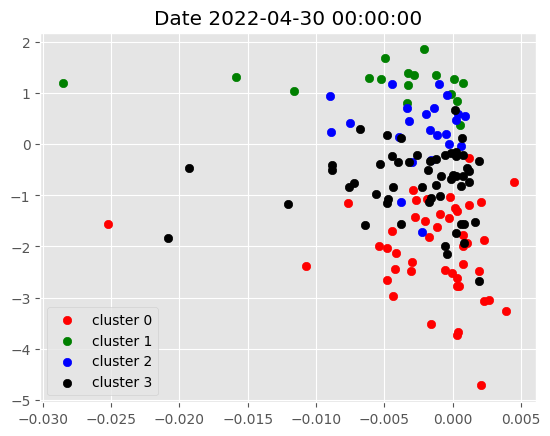

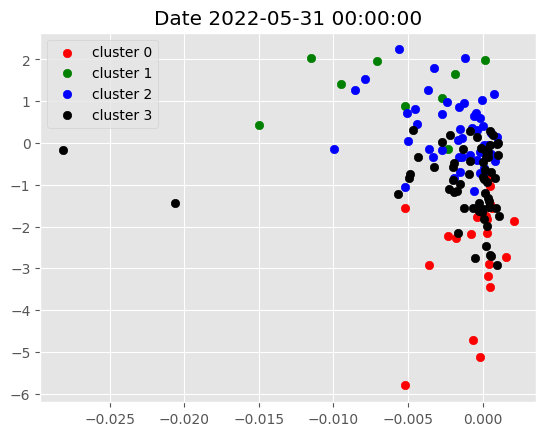

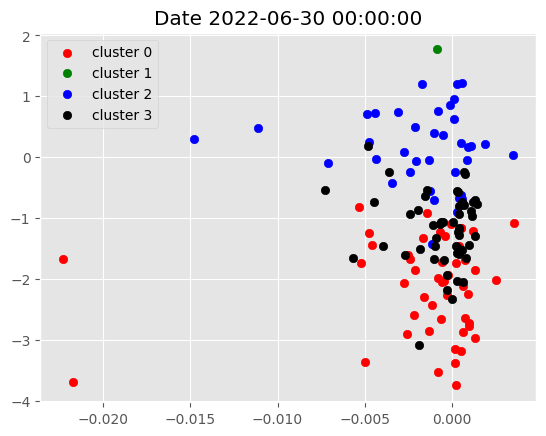

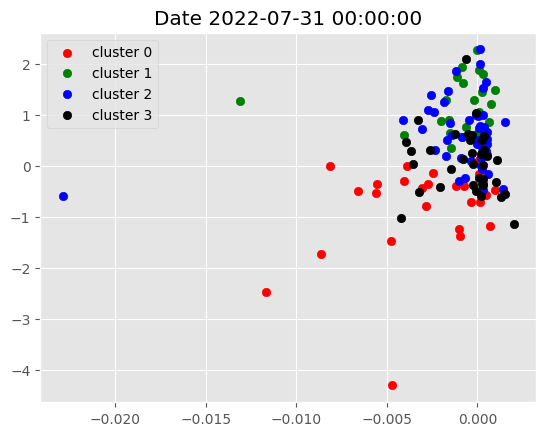

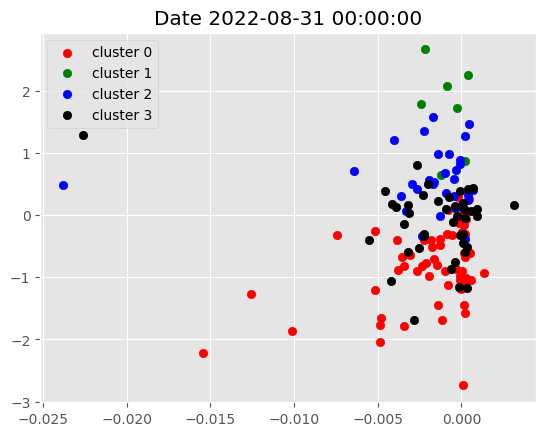

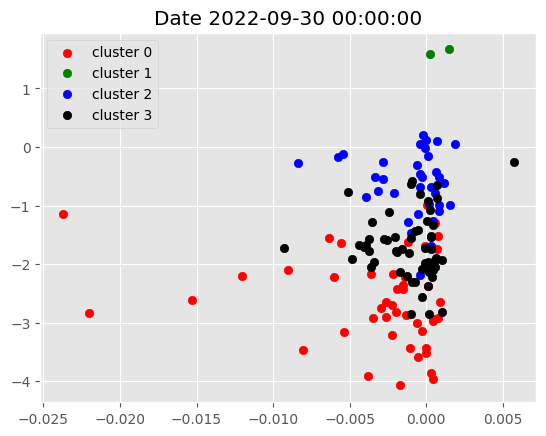

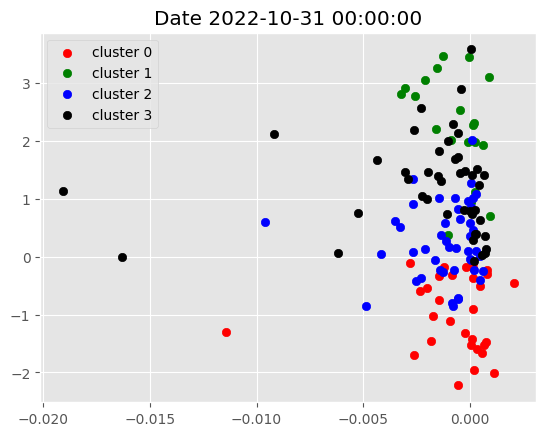

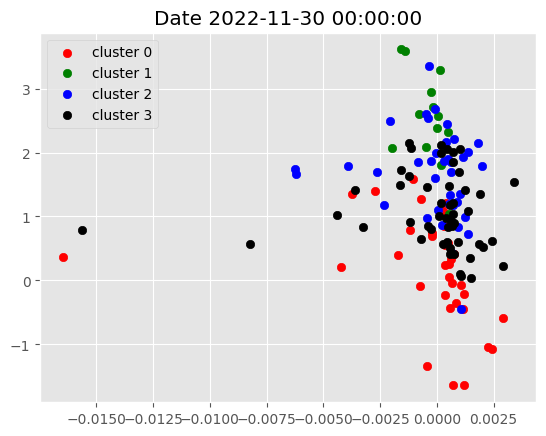

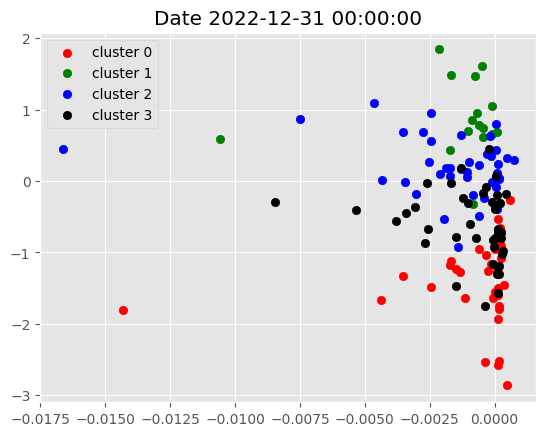

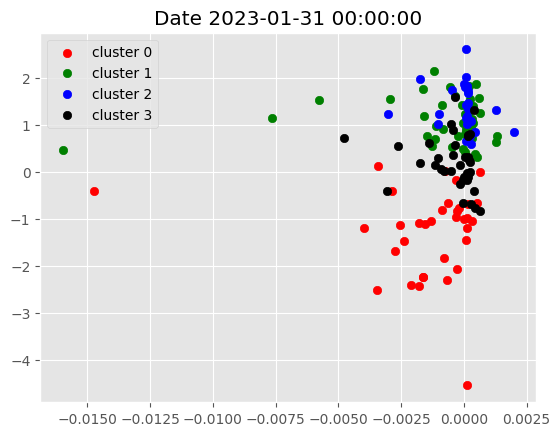

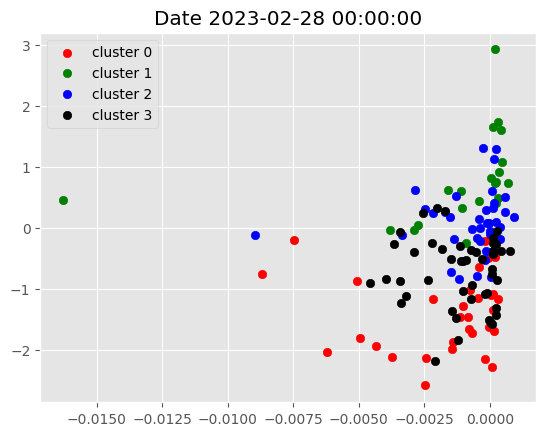

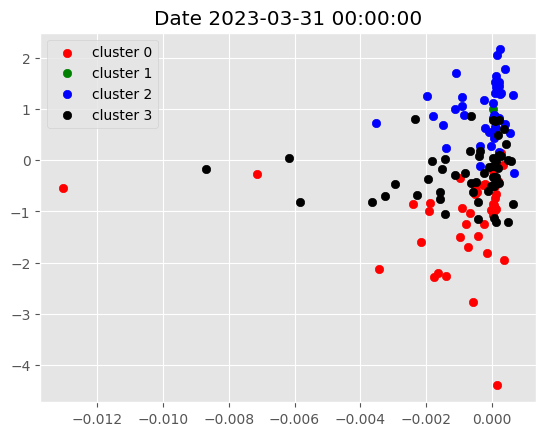

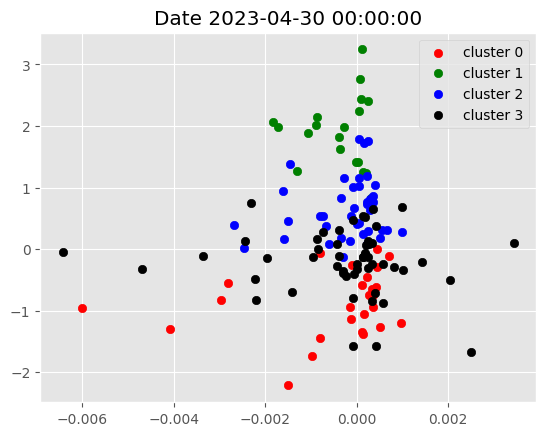

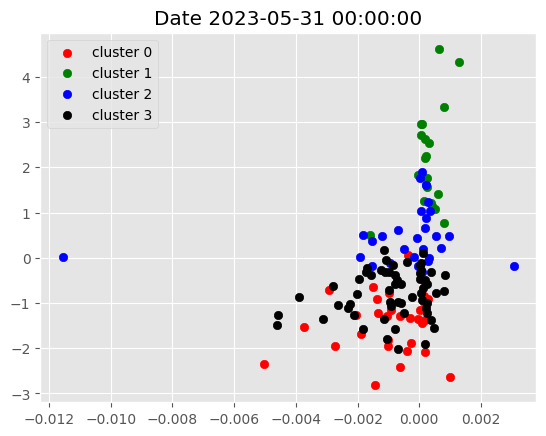

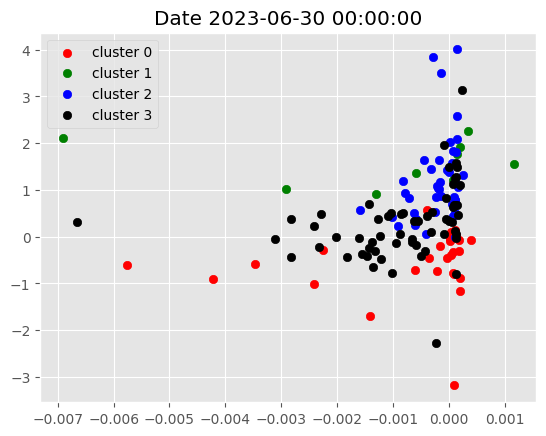

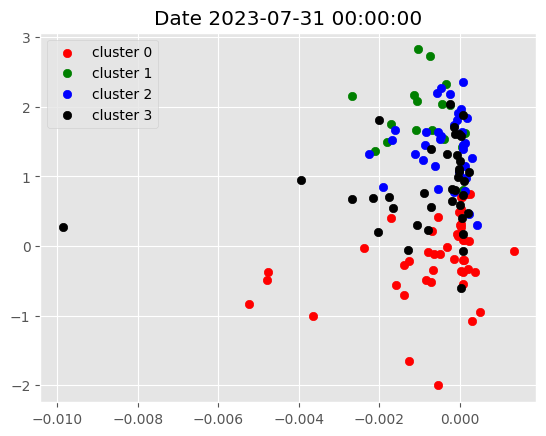

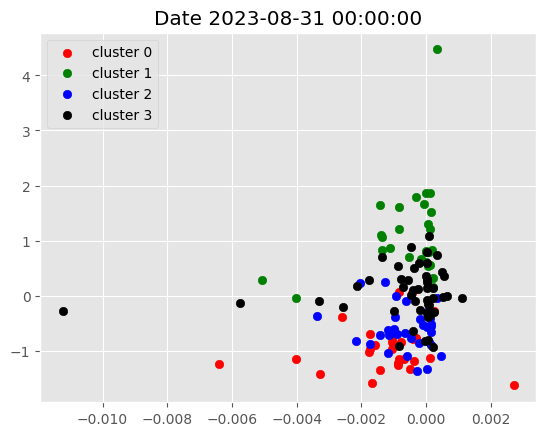

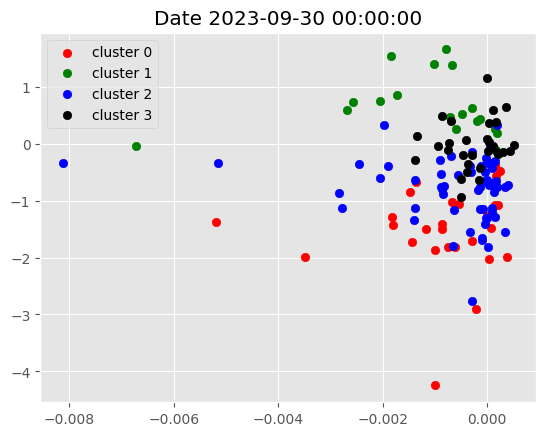

In [ ]:

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)



In [76]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [44]:


filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates


{'2017-11-01': ['ABBV',
  'ABT',
  'AZO',
  'BA',
  'BIIB',
  'BMY',
  'BRK-B',
  'C',
  'CL',
  'COST',
  'CSX',
  'CVX',
  'DAL',
  'DG',
  'EA',
  'EBAY',
  'F',
  'FCX',
  'FDX',
  'GM',
  'GS',
  'HD',
  'KR',
  'LMT',
  'LOW',
  'MDLZ',
  'MO',
  'MS',
  'ORLY',
  'OXY',
  'PANW',
  'PEP',
  'QCOM',
  'SBUX',
  'SCHW',
  'TGT',
  'TMO',
  'TSLA',
  'UNP',
  'UPS',
  'WFC',
  'WYNN'],
 '2017-12-01': ['AAPL',
  'ADBE',
  'AMGN',
  'AXP',
  'BAC',
  'BIIB',
  'BMY',
  'C',
  'CCL',
  'CL',
  'CMCSA',
  'CRM',
  'DHR',
  'EOG',
  'EXPE',
  'F',
  'FDX',
  'GILD',
  'GM',
  'GOOG',
  'GOOGL',
  'GS',
  'HUM',
  'IBM',
  'JNJ',
  'KO',
  'LOW',
  'MA',
  'MDT',
  'MET',
  'MRK',
  'MSFT',
  'PANW',
  'PYPL',
  'RTX',
  'SHW',
  'STZ',
  'TGT',
  'TMO',
  'TXN',
  'USB',
  'V',
  'WFC',
  'XOM'],
 '2018-01-01': ['ABBV',
  'ABT',
  'AIG',
  'AMZN',
  'AXP',
  'AZO',
  'BIIB',
  'BKNG',
  'CCL',
  'CHTR',
  'COST',
  'CSX',
  'DIS',
  'EA',
  'F',
  'GOOGL',
  'GS',
  'IBM',
  'INTC',
  '

In [46]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [47]:


stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df






[*********************100%***********************]  155 of 155 completed


Price            Close                                                 \
Ticker            AAPL        ABBV        ABT         ACN        ADBE   
Date                                                                    
2016-10-31   26.090456   38.834358  33.619495  101.760155  107.510002   
2016-11-01   25.619385   39.300823  33.456692  101.672607  106.870003   
2016-11-02   25.642361   39.537537  33.156834  103.834953  105.889999   
2016-11-03   25.367512   38.910946  32.882671  102.381721  107.169998   
2016-11-04   25.138847   39.015373  33.490982  102.626846  106.199997   
...                ...         ...        ...         ...         ...   
2023-09-25  174.569931  144.997543  94.104805  307.844971  511.600006   
2023-09-26  170.485275  144.303741  92.907631  301.649048  506.299988   
2023-09-27  168.968384  143.572449  92.231789  305.310303  502.600006   
2023-09-28  169.226151  142.747360  94.732376  292.092926  504.670013   
2023-09-29  169.741714  139.756470  93.506218  298.250031  509.899994   

Price                                                                  ...  \
Ticker             ADP        ADSK        AIG        AMAT         AMD  ...   
Date                                                                   ...   
2016-10-31   72.332787   72.279999  49.409809   26.357302    7.230000  ...   
2016-11-01   72.216476   70.099998  48.592983   26.194151    7.090000  ...   
2016-11-02   74.758858   68.680000  48.488880   25.913181    6.760000  ...   
2016-11-03   74.218834   67.610001  46.566936   25.623138    6.700000  ...   
2016-11-04   74.011101   69.440002  45.950321   25.577822    6.560000  ...   
...                ...         ...        ...         ...         ...  ...   
2023-09-25  231.056656  205.669998  59.895283  134.547714   97.379997  ...   
2023-09-26  228.380463  201.660004  59.056576  132.075256   95.959999  ...   
2023-09-27  233.569168  202.279999  58.815571  133.040588   98.070000  ...   
2023-09-28  234.223770  207.889999  59.075855  136.153366  102.760002  ...   
2023-09-29  231.595718  206.910004  58.420315  136.379898  102.820000  ...   

Price        Volume                                                           \
Ticker          VLO     VRTX        VZ       WBA     WDAY      WDC       WFC   
Date                                                                           
2016-10-31  4969500  1928200  12459400   4662100  1147300  4449514  20115900   
2016-11-01  7816800  2458200  13229400   5130800  1091400  5055315  20020200   
2016-11-02  7317600  2580400  16488200   9783100  1127800  5578033  19566600   
2016-11-03  3855900  2371000  12605100   4586500   633300  4223810  14982700   
2016-11-04  3729900  1902100  14410200   7023900   892600  3579509  27391600   
...             ...      ...       ...       ...      ...      ...       ...   
2023-09-25  3241900   698100  17616900   6891000   894200  3553446  10624000   
2023-09-26  4936800   633600  18841600   7570500  1217300  4724565  15219400   
2023-09-27  3644000   860600  22083500  10182900  2338100  3370739  11815500   
2023-09-28  3587300   578900  18772100   7291500  9196300  4342086  12454600   
2023-09-29  4302200   896800  19759400  25659100  4066600  3323376  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 775 columns]

In [50]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

KeyError: 'Adj Close'